In [1]:
# incorporate drift into the LV model and see if we can find anything interesting

In [12]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import torch
import pickle
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import lvutils
import utils as mutils
import lvutils as lv
import mattplotlib as m
import modellib

def redo():
    reload(mutils)
    reload(lv)
    reload(m)
    reload(modellib)

In [13]:
print('running')

running


# load the data

In [14]:
data = mutils.load_data('ki_0503_V2b_py.mat') # this is a better dataset to use

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


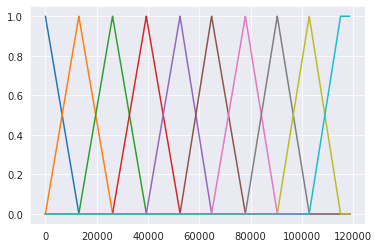

In [21]:
plt.plot(data.Xdrift)
plt.show()

# train the drift model

In [15]:
redo()
LLsNULL, drift_net, drift_mod = modellib.train_drift(data)

Mean LL-null: 2.50852


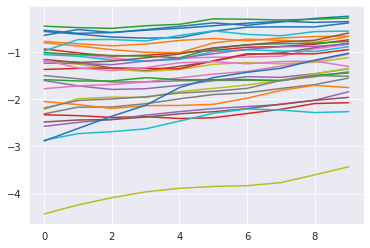

In [16]:
dw = drift_mod.get_weights()
plt.plot(dw)
#plt.ylim([-4, 2])
plt.show()

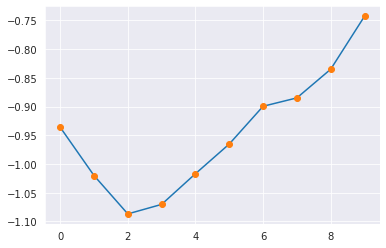

In [17]:
plt.plot(dw[:,3])
plt.plot(dw[:,3],'o')
plt.show()

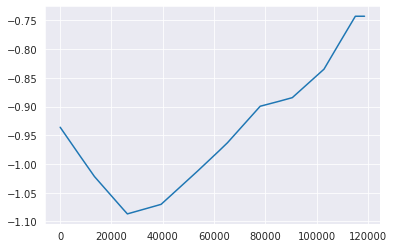

In [18]:
plt.plot(data.Xdrift.numpy()@dw[:,3])

# train the GLM+drift network

In [9]:
redo()
LLs0, glm = model.train_glm_with_drift(data, drift_net, drift_mod)
print("LLs:", np.mean(LLsNULL-LLs0))

LLs: 0.052399036


# train the autoencoder+GLM+drift network


In [10]:
lls, big_model = model.train_autoencoder_and_glm(data, num_latents=3, pretrained_glm=glm)

Model: M031_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 32.602362632751465 sec elapsed


<Figure size 432x288 with 0 Axes>

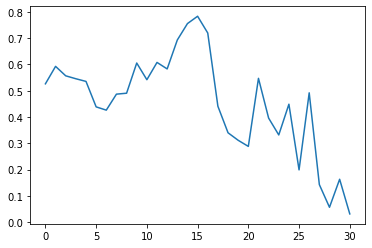

In [11]:
m.fig()
plt.plot(lls)
plt.show()

In [12]:
# plot the latents over the trials to see if anything improved
R = mutils.construct_R_matrix(data)
Z = mutils.construct_Z_matrix(R, big_model, num_latents=3)

<Figure size 432x288 with 0 Axes>

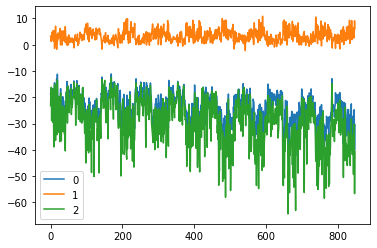

In [13]:
m.fig()
plt.plot(np.mean(Z, axis=1).T[0], label='0')
plt.plot(np.mean(Z, axis=1).T[1], label='1')
plt.plot(np.mean(Z, axis=1).T[2], label='2')
plt.legend()
plt.show()

# compare the latents against trial vars and project

<Figure size 432x288 with 0 Axes>

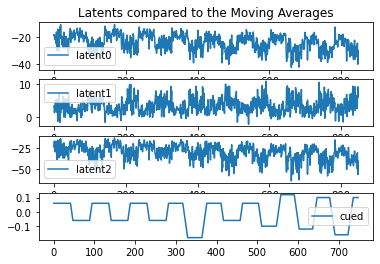

In [20]:
redo()
latent0 = np.mean(Z, axis=1).T[0]
latent1 = np.mean(Z, axis=1).T[1]
latent2 = np.mean(Z, axis=1).T[2]
m.fig()
m.plots((latent0, "latent0"),
        (latent1, "latent1"),
        (latent2, "latent2"),
        #(lv.movavg(data.TRstim, 100), "stim"),
        #(lv.movavg(data.TRchoice, 100), "choice"),
        (lv.movavg(data.TRcued, 100), "cued"),
        #(lv.movavg(data.TRsignal, 100), "signal"),
        #(lv.movavg(data.TRstrength, 100), "strength"),
        title="Latents compared to the Moving Averages")

In [21]:
# calculate the cued-uncued vectors
centroid_vector = lv.centroid_vector(Z, data.TRcued)
hyperplane_vector = lv.hyperplane_vector(Z, data.TRcued)
centroid_vector, hyperplane_vector

(array([[ 0.57356482, -0.17883075,  0.79940162]]),
 array([[-0.98759979,  0.01651235,  0.15612171]]))

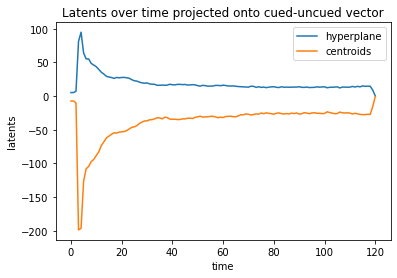

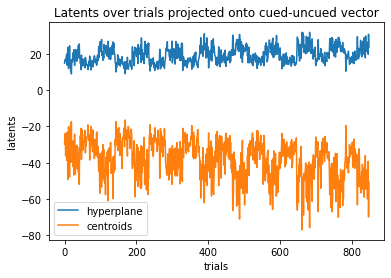

In [22]:
## 4a project the latents over time onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued-uncued vector")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()
plt.show()

## 4b project the latents over trials onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=1).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=1).T).T, label="centroids")
plt.title("Latents over trials projected onto cued-uncued vector")
plt.xlabel("trials")
plt.ylabel("latents")
plt.legend()
plt.show()

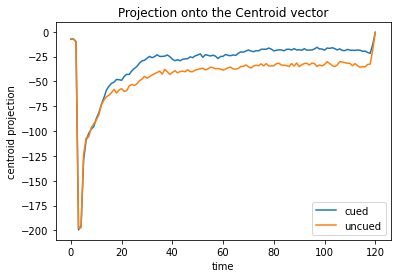

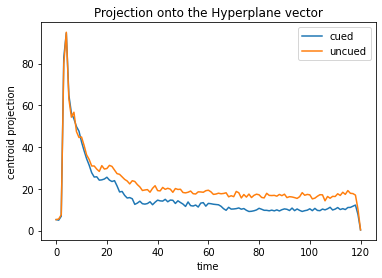

In [23]:
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]

fig = plt.figure()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid vector")
plt.show()

trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]

fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Hyperplane vector")
plt.show()

In [24]:
# you would do it on Robs (many possible ways, with many possible time scales) and then insert as a covariate back into the dataset. Then the autoencoder would work on that covariate…. Once you figure out a good way to smooth, then you can make a function….

# also, keep in mind that if you smooth, the autoencoder will have WORSE performance: but we want the latents to explain the attention signal better (rather than explain the detailed response). So, you’d know its a good LV model by having smoother latents, and having them better predict the attention signal than the unsmoothed latents….

# handle the raw robs, don't worry about my weird cube

In [25]:
redo()
def smooth(robs):
    nt = robs.shape[0]
    nc = robs.shape[1] # number of cells
    smoothed = np.zeros((nt, nc))
    for i in range(nc): # for each cell
        smoothed[:, i] = lv.mov_avg(robs[:, i], 100, mode='same')
    return smoothed

In [26]:
sm_robs10 = smooth(data.robs)
sm_robs10.shape

(118679, 31)

In [27]:
# # it turns out that trials*timepoints doesn't work as the trials have space between them
# # and some timepoints are not valid
# a = R[:, :, 0].reshape(R.shape[0]*R.shape[1])
# sm_robs10 = smooth(R)
# #sm_robs10.shape[0], data.NT
# R.shape[0]*R.shape[1], a.shape, data.robs.shape, len(data.block_inds), \
# max([len(data.block_inds[i]) for i in range(len(data.block_inds))])
# data.robs.shape, sum([len(blk) for blk in data.block_inds])
# 
# #m.fig()
# #plt.hist([len(blk) for blk in data.block_inds])
# #plt.show()
# 
# data.block_inds[-1][-1], data.robs.shape[0]
# data.robs.shape

# insert back into Dataset object as covariates and retrain everything

In [28]:
data.add_covariate('smoothed_robs', sm_robs10)

In [29]:
# retrain the model
redo()
LLsNULL, drift_net, drift_mod = model.train_drift(data)
LLs0, glm = model.train_glm_with_drift(data, drift_net, drift_mod)
lls, smooth_model = model.train_autoencoder_and_glm(data, num_latents=3, pretrained_glm=glm)

Mean LL-null: 2.5085356
Model: M031_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 28.9039249420166 sec elapsed


# Look at the results of the smoothed model

In [30]:
Z = mutils.construct_Z_matrix(R, big_model, num_latents=3)

<Figure size 432x288 with 0 Axes>

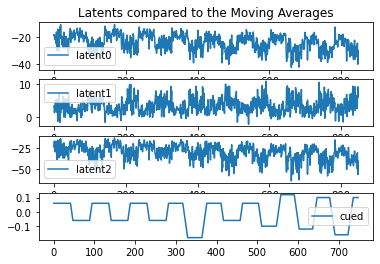

In [31]:
redo()
latent0 = np.mean(Z, axis=1).T[0]
latent1 = np.mean(Z, axis=1).T[1]
latent2 = np.mean(Z, axis=1).T[2]
m.fig()
m.plots((latent0, "latent0"),
        (latent1, "latent1"),
        (latent2, "latent2"),
        #(lv.movavg(data.TRstim, 100), "stim"),
        #(lv.movavg(data.TRchoice, 100), "choice"),
        (lv.movavg(data.TRcued, 100), "cued"),
        #(lv.movavg(data.TRsignal, 100), "signal"),
        #(lv.movavg(data.TRstrength, 100), "strength"),
        title="Latents compared to the Moving Averages")

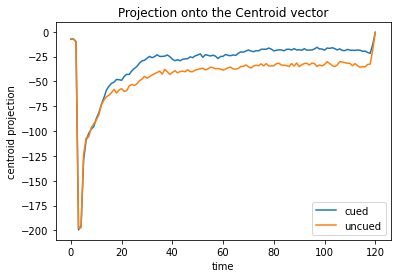

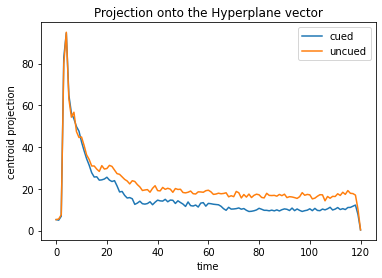

In [32]:
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]

fig = plt.figure()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid vector")
plt.show()

trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]

fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Hyperplane vector")
plt.show()

# document the work I did to identify the latents and that they are related to the drift
then that we add in the drift term to remove that from the data. Organize this analysis and result into its own sub notebook, and link it from the top notebook. Then we can try to look for attention again.


# SCRATCH